In [ ]:
# TODO
# ADD STANDARD STATE, LJLRC TO CORRECTION TERMS
# SAVE OM AND PLOT CORRELATION STDEV DDG AND OM VALUES
# RUN ON 50NS WINDOWS DATASET
# PLOT BRUTE FORCE (THRESHOLD 0.0) VS ADAPTIVE (THRESHOLD 0.1)
# EXPORT CONVERGENCE PLOTS

# ADAPT SCRIPT FOR MANUALLY RESUBMITTING JOBS TO EXTEND NOISY-WINDOWS (FOR OTHER SYSTEMS)

In [1]:
import glob,sys,os
import numpy as np
import math
import matplotlib.pyplot as plt
# ADAPTIVE SAMPLING ROUTE
NEPOCHS = 2
EPOCHTIME = 5 # ns  
DISCARD = 0.5 # ns
CHUNKSIZE = 0.5 # ns
THRESHOLD = 0.1 #kcal/mol
TIMESTEP = 0.000004 #ns

In [2]:
def doMBAR(simfiles, startime, endtime, sim_maxtimes):
    cmd = "rm -rf tmp ; mkdir tmp" 
    os.system(cmd)
    cumtime = 0.0
    for simfile in simfiles:
        max_time = sim_maxtimes[simfile]
        #print (simfile, max_time)
        # Ugly
        lamval = os.path.split(simfile)[-2].split("/")[-1]
        #print (lamval)
        istream = open(simfile,'r')
        ostream = open("tmp/%s.dat" % lamval,'w')
        ifile = istream.readlines()
        for line in ifile:
            if line.startswith("#"):
                ostream.write(line)
                continue
            elems = line.split()
            time = float(elems[0])*TIMESTEP
            if time < startime:
                continue
            if (time > endtime or time > max_time):
                break
            ostream.write(line)
        cumtime += (time - startime)
        istream.close()
        ostream.close()
    # TODO ADD OVERLAP MATRIX TO OUTPUT
    cmd = "~/sire.app/bin/analyse_freenrg mbar -i tmp/*.dat -o tmp/mbar.dat -p 100"
    os.system(cmd)
    istream = open("tmp/mbar.dat","r")
    results = {}
    ofile = istream.readlines()
    inDGsection = False
    for line in ofile:
        if line.startswith("#DG from neighbouring"):
            inDGsection = True
            continue
        if line.startswith("#PMF from MBAR"):
            inDGsection = False
            continue
        if inDGsection:
            elems = line.split()
            lami = float(elems[0])
            lamj = float(elems[1])
            DGij = float(elems[2])
            DGij_sig = float(elems[3])
            results["%.5f-%.5f" % (lami,lamj)] = (DGij,DGij_sig)
    totline = ofile[-3].split()
    mbar = float(totline[0].strip(","))
    mbar_err = float(totline[1])
    results['DGtot'] = (mbar,mbar_err,cumtime)
        
    return results


In [3]:
def getNoisyWindows(energies,endtime, mythreshold=THRESHOLD):
    noisy_windows = []
    for leg in ("bound","free"):
        for stage in ("discharge","vanish"):
            windows = list(energies[1][leg][stage][(DISCARD,endtime)].keys())
            windows.remove('DGtot')
            avg_windows = {}
            for window in windows:
                avg_windows[window] = []
                vals = []
                for run in range(1,4):
                    vals.append(energies[run][leg][stage][(DISCARD,endtime)][window][0])
                std = np.array(vals).std()
                avg_windows[window] = std
                if std > mythreshold:
                    noisy_windows.append( [leg, stage, window, std] )
    return noisy_windows

In [4]:
def calcEnergies(energies, basefolder, simprofile, epoch):
    for run in range(1,4):
        for leg in ("bound","free"):
            for stage in ("discharge","vanish"):
                rundir = "%s/%s/run00%d/%s/output/lambda-*/simfile.dat" % (basefolder,leg,run,stage)
                simfiles = glob.glob(rundir)
                sim_maxtimes = {}
                for simfile in simfiles:
                    maxtime = simprofile[run][leg][stage][simfile]
                    sim_maxtimes[simfile] = maxtime
                # use analyse_freenrg to get free energy of chunks
                nchunks = int((epoch*EPOCHTIME)/CHUNKSIZE)
                for chunk in range(1,nchunks):
                    try:
                        energies[run]
                    except KeyError:
                        energies[run] = {}
                    try:
                        energies[run][leg]
                    except KeyError:
                        energies[run][leg] = {}
                    try:
                        energies[run][leg][stage] 
                    except KeyError:
                        energies[run][leg][stage] = {}
                    startime = DISCARD
                    endtime = (chunk+1)*CHUNKSIZE
                    try:
                        energies[run][leg][stage][(startime,endtime)]
                    except KeyError:
                        DG = doMBAR(simfiles, startime, endtime, sim_maxtimes)
                        print ("MBAR on %s, start %s, end %s, DG %s " % (rundir,startime,endtime,DG))
                        # TODO ADD LJLRC term
                        # TODO ADD STANDARD STATE CORRECTION TERM                        
                        energies[run][leg][stage][(startime,endtime)] = DG

In [18]:
def plotDGbind(energies):
    runs = list(energies.keys())
    chunks = energies[runs[0]]['bound']['discharge'].keys()
    list(chunks).sort()
    x_vals = []
    y_vals = []
    error_vals = []
    y_run1 = []
    y_run2 = []
    y_run3 = []
    y_runs = [y_run1, y_run2, y_run3]
    for chunk in chunks:
        DGbinds = []
        cumtime = 0.0  
        for run in runs:
            DG_bound_discharge = energies[run]['bound']['discharge'][chunk]['DGtot'][0]
            DG_bound_discharge_time = energies[run]['bound']['discharge'][chunk]['DGtot'][2]
            DG_bound_vanish = energies[run]['bound']['vanish'][chunk]['DGtot'][0]
            DG_bound_vanish_time = energies[run]['bound']['vanish'][chunk]['DGtot'][2]
            DG_free_discharge = energies[run]['free']['discharge'][chunk]['DGtot'][0]
            DG_free_discharge_time = energies[run]['free']['discharge'][chunk]['DGtot'][2]            
            DG_free_vanish = energies[run]['free']['vanish'][chunk]['DGtot'][0]
            DG_free_vanish_time = energies[run]['free']['vanish'][chunk]['DGtot'][2]            
            DGbind = (DG_free_discharge + DG_free_vanish) -  (DG_bound_discharge + DG_bound_vanish)
            DGbinds.append(DGbind)
            chunktime = DG_bound_discharge_time + DG_bound_vanish_time + DG_free_discharge_time + DG_free_vanish_time
            cumtime += chunktime
            y_runs[run-1].append(DGbind)
            #print (chunk,DGbind)
        DGbind_avg = np.array(DGbinds).mean()
        DGbind_ste = np.array(DGbinds).std()/math.sqrt(len(DGbinds))*1.96# 95% CI
        print (chunk[1], DGbind_avg,DGbind_ste)
        #x_vals.append(chunk[1])
        x_vals.append(cumtime)
        y_vals.append(DGbind_avg)
        error_vals.append(DGbind_ste)
    
    #print (x_vals)
    # Convergence plot
    plt.plot(x_vals,y_vals)
    for entry in y_runs:
        plt.plot(x_vals,entry)
    plt.ylabel('DG / kcal.mol-1')
    plt.xlabel('Cumulative sampling time / ns')
    plt.fill_between(x_vals, np.array(y_vals)-np.array(error_vals), np.array(y_vals)+np.array(error_vals), alpha=0.5, facecolor='#ffa500' )
    plt.show()

In [6]:
def updateSimProfile(simprofile,noisy_windows,samplingtime):
    for run in range(1,4):
        for leg in ("bound","free"):
            for stage in ("discharge","vanish"):
                simfiles = simprofile[run][leg][stage].keys()
                #print (simfiles)
                for simfile in simfiles:
                    # Ugly
                    lamval = float(os.path.split(simfile)[-2].split("/")[-1].strip("lambda-"))
                    #print (simfile)
                    for window in noisy_windows:
                        noisyleg = window[0]
                        noisystage = window[1]
                        noisylami, noisylamj = window[2].split('-')
                        noisylami = float(noisylami)
                        noisylamj = float(noisylamj)
                        if (leg == noisyleg and stage == noisystage 
                            and (abs(lamval-noisylami) < 0.01 or 
                                 abs(lamval-noisylamj) < 0.01) ):
                            print ("%s noisy, extending sampling to %s" % (simfile,samplingtime))
                            simprofile[run][leg][stage][simfile] = samplingtime
                            break
                    


## Compute free energy using cumulative chunks of CHUNKSIZE, starting from DISCARD to allow for some re-equilibration (e.g. 0.5 - 1 ; 0.5 - 1.5 ; 0.5 - 2 ; 0.5 - 2.5 ; .... ; 0.5 - 5 ns)

In [7]:
basefolder = "sim"

energies={}
simprofile={}
# initially use 1*EPOCHTIME for all windows as maximum sampling time
for run in range(1,4):
    simprofile[run] = {}
    for leg in ("bound","free"):
        simprofile[run][leg] = {}
        for stage in ("discharge","vanish"):
            simprofile[run][leg][stage] = {}
            rundir = "%s/%s/run00%d/%s/output/lambda-*/simfile.dat" % (basefolder,leg,run,stage)
            simfiles = glob.glob(rundir)
            for simfile in simfiles:
                simprofile[run][leg][stage][simfile] = EPOCHTIME
print (simprofile)

{1: {'bound': {'discharge': {'sim/bound/run001/discharge/output/lambda-0.000/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.050/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.100/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.200/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.300/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.400/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.500/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.600/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.700/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.800/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-0.900/simfile.dat': 5, 'sim/bound/run001/discharge/output/lambda-1.000/simfile.dat': 5}, 'vanish': {'sim/bound/run001/vanish/output/lambda-0.000/simfile.dat': 5, 'sim/bound/run001/vanish/output/lambda-0.025/simfile.dat': 5, 'sim/bound/run001/vanish/output/lambda-0.050/simfile.da

In [8]:
# Now compute energies for each sim using variable chunks
calcEnergies(energies, basefolder, simprofile, 1)

MBAR on sim/bound/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 1.0, DG {'0.00000-0.05000': (12.7509, 0.0057), '0.05000-0.10000': (12.0278, 0.0051), '0.10000-0.20000': (21.9056, 0.0103), '0.20000-0.30000': (19.0769, 0.0103), '0.30000-0.40000': (16.3582, 0.0091), '0.40000-0.50000': (13.7345, 0.0083), '0.50000-0.60000': (11.1665, 0.0077), '0.60000-0.70000': (8.6394, 0.0072), '0.70000-0.80000': (6.1539, 0.0067), '0.80000-0.90000': (3.7121, 0.0063), '0.90000-1.00000': (1.311, 0.0067), 'DGtot': (126.836699, 0.044501, 6.0047999999999995)} 
MBAR on sim/bound/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 1.5, DG {'0.00000-0.05000': (12.7609, 0.004), '0.05000-0.10000': (12.0385, 0.0035), '0.10000-0.20000': (21.9402, 0.0072), '0.20000-0.30000': (19.1141, 0.0074), '0.30000-0.40000': (16.3717, 0.0066), '0.40000-0.50000': (13.7295, 0.0059), '0.50000-0.60000': (11.1574, 0.0055), '0.60000-0.70000': (8.6298, 0.0051), '0.70000-0.80000': (6.1423, 0.0047), '0.80000-0.90000':

MBAR on sim/bound/run001/vanish/output/lambda-*/simfile.dat, start 0.5, end 3.0, DG {'0.00000-0.02500': (-14.6983, 0.0194), '0.02500-0.05000': (-8.8115, 0.0171), '0.05000-0.07500': (-4.8595, 0.0152), '0.07500-0.10000': (-2.4945, 0.0163), '0.10000-0.12500': (-1.3913, 0.0158), '0.12500-0.15000': (-0.169, 0.0124), '0.15000-0.20000': (1.5129, 0.0443), '0.20000-0.25000': (1.1844, 0.0471), '0.25000-0.30000': (0.3265, 0.044), '0.30000-0.35000': (0.0434, 0.0333), '0.35000-0.40000': (-0.2391, 0.0337), '0.40000-0.45000': (-0.6238, 0.0277), '0.45000-0.50000': (-1.0119, 0.0306), '0.50000-0.55000': (0.1025, 0.0153), '0.55000-0.60000': (0.8748, 0.0147), '0.60000-0.65000': (0.7022, 0.0151), '0.65000-0.70000': (0.7731, 0.0098), '0.70000-0.75000': (0.9623, 0.0061), '0.75000-0.80000': (1.5243, 0.0025), '0.80000-0.85000': (1.9375, 0.0011), '0.85000-0.90000': (1.914, 0.0009), '0.90000-0.95000': (1.6742, 0.001), '0.95000-0.97000': (0.6247, 0.0004), '0.97000-0.99000': (0.6906, 0.0004), '0.99000-1.00000': (0

MBAR on sim/free/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 4.0, DG {'0.00000-0.05000': (13.0756, 0.0022), '0.05000-0.10000': (12.3583, 0.002), '0.10000-0.20000': (22.5847, 0.0041), '0.20000-0.30000': (19.7819, 0.0042), '0.30000-0.40000': (17.0236, 0.0041), '0.40000-0.50000': (14.2947, 0.004), '0.50000-0.60000': (11.5959, 0.0039), '0.60000-0.70000': (8.9373, 0.0037), '0.70000-0.80000': (6.3287, 0.0035), '0.80000-0.90000': (3.7731, 0.0033), '0.90000-1.00000': (1.2568, 0.0035), 'DGtot': (131.010719, 0.019452, 42.004799999999996)} 
MBAR on sim/free/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 4.5, DG {'0.00000-0.05000': (13.0754, 0.0021), '0.05000-0.10000': (12.3595, 0.0019), '0.10000-0.20000': (22.5892, 0.0038), '0.20000-0.30000': (19.7855, 0.0039), '0.30000-0.40000': (17.0244, 0.0039), '0.40000-0.50000': (14.2934, 0.0038), '0.50000-0.60000': (11.5926, 0.0036), '0.60000-0.70000': (8.9321, 0.0035), '0.70000-0.80000': (6.3236, 0.0032), '0.80000-0.90000': (

MBAR on sim/free/run001/vanish/output/lambda-*/simfile.dat, start 0.5, end 4.5, DG {'0.00000-0.02500': (-14.8581, 0.0139), '0.02500-0.05000': (-9.3389, 0.0124), '0.05000-0.07500': (-5.7034, 0.0115), '0.07500-0.10000': (-3.4465, 0.0111), '0.10000-0.12500': (-1.9373, 0.0098), '0.12500-0.15000': (-0.9281, 0.0094), '0.15000-0.20000': (-0.5612, 0.0291), '0.20000-0.25000': (-0.0943, 0.0285), '0.25000-0.30000': (-0.2411, 0.0232), '0.30000-0.35000': (-0.5641, 0.0222), '0.35000-0.40000': (-1.0278, 0.0218), '0.40000-0.45000': (-1.6129, 0.0224), '0.45000-0.50000': (-2.4658, 0.0225), '0.50000-0.55000': (-2.653, 0.0179), '0.55000-0.60000': (-1.9592, 0.0131), '0.60000-0.65000': (-1.0292, 0.01), '0.65000-0.70000': (-0.183, 0.0066), '0.70000-0.75000': (0.5754, 0.0032), '0.75000-0.80000': (1.1591, 0.0014), '0.80000-0.85000': (1.3963, 0.0006), '0.85000-0.90000': (1.3524, 0.0003), '0.90000-0.95000': (1.2036, 0.0002), '0.95000-0.97000': (0.4594, 0.0001), '0.97000-0.99000': (0.5158, 0.0001), '0.99000-1.000

MBAR on sim/bound/run002/vanish/output/lambda-*/simfile.dat, start 0.5, end 1.5, DG {'0.00000-0.02500': (-14.8309, 0.0259), '0.02500-0.05000': (-8.8162, 0.031), '0.05000-0.07500': (-4.8832, 0.0218), '0.07500-0.10000': (-2.5847, 0.028), '0.10000-0.12500': (-0.7514, 0.0168), '0.12500-0.15000': (0.5886, 0.0206), '0.15000-0.20000': (1.307, 0.0976), '0.20000-0.25000': (0.0521, 0.0977), '0.25000-0.30000': (1.1552, 0.037), '0.30000-0.35000': (0.8196, 0.0734), '0.35000-0.40000': (-0.516, 0.0497), '0.40000-0.45000': (-1.1139, 0.0607), '0.45000-0.50000': (-1.159, 0.0428), '0.50000-0.55000': (-0.1348, 0.0271), '0.55000-0.60000': (0.5161, 0.0276), '0.60000-0.65000': (0.502, 0.0226), '0.65000-0.70000': (0.5778, 0.0162), '0.70000-0.75000': (1.0134, 0.0081), '0.75000-0.80000': (1.6014, 0.0038), '0.80000-0.85000': (1.934, 0.0018), '0.85000-0.90000': (1.8588, 0.0016), '0.90000-0.95000': (1.6011, 0.0015), '0.95000-0.97000': (0.5939, 0.0006), '0.97000-0.99000': (0.6552, 0.0007), '0.99000-1.00000': (0.697

MBAR on sim/free/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 1.0, DG {'0.00000-0.05000': (13.1607, 0.0069), '0.05000-0.10000': (12.3854, 0.006), '0.10000-0.20000': (22.553, 0.0112), '0.20000-0.30000': (19.7355, 0.011), '0.30000-0.40000': (16.9895, 0.0108), '0.40000-0.50000': (14.2837, 0.0104), '0.50000-0.60000': (11.599, 0.0103), '0.60000-0.70000': (8.9335, 0.0099), '0.70000-0.80000': (6.3128, 0.0093), '0.80000-0.90000': (3.745, 0.0087), '0.90000-1.00000': (1.2362, 0.0091), 'DGtot': (130.934233, 0.051963, 6.0047999999999995)} 
MBAR on sim/free/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 1.5, DG {'0.00000-0.05000': (13.123, 0.0046), '0.05000-0.10000': (12.3722, 0.004), '0.10000-0.20000': (22.5629, 0.0078), '0.20000-0.30000': (19.7407, 0.008), '0.30000-0.40000': (16.9841, 0.0076), '0.40000-0.50000': (14.2773, 0.0074), '0.50000-0.60000': (11.5894, 0.0073), '0.60000-0.70000': (8.9253, 0.007), '0.70000-0.80000': (6.3098, 0.0065), '0.80000-0.90000': (3.7503,

MBAR on sim/free/run002/vanish/output/lambda-*/simfile.dat, start 0.5, end 3.0, DG {'0.00000-0.02500': (-14.7826, 0.0185), '0.02500-0.05000': (-9.339, 0.0156), '0.05000-0.07500': (-5.7173, 0.0149), '0.07500-0.10000': (-3.4584, 0.0139), '0.10000-0.12500': (-1.9405, 0.0126), '0.12500-0.15000': (-0.9511, 0.012), '0.15000-0.20000': (-0.5261, 0.0379), '0.20000-0.25000': (-0.3559, 0.0341), '0.25000-0.30000': (-0.2609, 0.0307), '0.30000-0.35000': (-0.5591, 0.0281), '0.35000-0.40000': (-0.9837, 0.0262), '0.40000-0.45000': (-1.6021, 0.0279), '0.45000-0.50000': (-2.3699, 0.0277), '0.50000-0.55000': (-2.5941, 0.0228), '0.55000-0.60000': (-1.9283, 0.0169), '0.60000-0.65000': (-1.0117, 0.0124), '0.65000-0.70000': (-0.1771, 0.0083), '0.70000-0.75000': (0.583, 0.0041), '0.75000-0.80000': (1.1618, 0.0017), '0.80000-0.85000': (1.398, 0.0008), '0.85000-0.90000': (1.3538, 0.0004), '0.90000-0.95000': (1.205, 0.0003), '0.95000-0.97000': (0.4599, 0.0001), '0.97000-0.99000': (0.5165, 0.0001), '0.99000-1.0000

MBAR on sim/bound/run003/discharge/output/lambda-*/simfile.dat, start 0.5, end 4.0, DG {'0.00000-0.05000': (12.7441, 0.002), '0.05000-0.10000': (12.0343, 0.0018), '0.10000-0.20000': (21.9495, 0.0037), '0.20000-0.30000': (19.1594, 0.0038), '0.30000-0.40000': (16.4535, 0.0035), '0.40000-0.50000': (13.8147, 0.0032), '0.50000-0.60000': (11.2187, 0.0031), '0.60000-0.70000': (8.6634, 0.0029), '0.70000-0.80000': (6.156, 0.0026), '0.80000-0.90000': (3.6916, 0.0025), '0.90000-1.00000': (1.2621, 0.0028), 'DGtot': (127.14726, 0.016999, 42.004799999999996)} 
MBAR on sim/bound/run003/discharge/output/lambda-*/simfile.dat, start 0.5, end 4.5, DG {'0.00000-0.05000': (12.7499, 0.0019), '0.05000-0.10000': (12.0383, 0.0017), '0.10000-0.20000': (21.9579, 0.0035), '0.20000-0.30000': (19.17, 0.0035), '0.30000-0.40000': (16.4626, 0.0033), '0.40000-0.50000': (13.8199, 0.0031), '0.50000-0.60000': (11.2173, 0.0029), '0.60000-0.70000': (8.6559, 0.0027), '0.70000-0.80000': (6.147, 0.0025), '0.80000-0.90000': (3.

MBAR on sim/bound/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 4.5, DG {'0.00000-0.02500': (-15.1618, 0.0154), '0.02500-0.05000': (-9.2062, 0.0146), '0.05000-0.07500': (-4.9911, 0.0107), '0.07500-0.10000': (-2.3763, 0.0124), '0.10000-0.12500': (-0.846, 0.0105), '0.12500-0.15000': (0.132, 0.0104), '0.15000-0.20000': (1.4626, 0.0331), '0.20000-0.25000': (2.0701, 0.0336), '0.25000-0.30000': (1.0297, 0.029), '0.30000-0.35000': (0.3171, 0.0316), '0.35000-0.40000': (-0.3409, 0.0257), '0.40000-0.45000': (-0.6501, 0.0228), '0.45000-0.50000': (-0.5631, 0.0195), '0.50000-0.55000': (-0.014, 0.0145), '0.55000-0.60000': (0.4191, 0.0139), '0.60000-0.65000': (0.4901, 0.0105), '0.65000-0.70000': (0.8269, 0.0081), '0.70000-0.75000': (1.0936, 0.0048), '0.75000-0.80000': (1.6526, 0.002), '0.80000-0.85000': (1.9201, 0.0011), '0.85000-0.90000': (1.8025, 0.0008), '0.90000-0.95000': (1.5541, 0.0007), '0.95000-0.97000': (0.5812, 0.0003), '0.97000-0.99000': (0.6453, 0.0003), '0.99000-1.00000': (0.

MBAR on sim/free/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 2.0, DG {'0.00000-0.02500': (-15.1381, 0.0253), '0.02500-0.05000': (-9.5902, 0.0193), '0.05000-0.07500': (-5.7903, 0.0188), '0.07500-0.10000': (-3.4708, 0.0181), '0.10000-0.12500': (-2.0448, 0.0168), '0.12500-0.15000': (-0.9527, 0.0148), '0.15000-0.20000': (-0.5132, 0.05), '0.20000-0.25000': (-0.0988, 0.0436), '0.25000-0.30000': (-0.1719, 0.0395), '0.30000-0.35000': (-0.5936, 0.0363), '0.35000-0.40000': (-0.8735, 0.0329), '0.40000-0.45000': (-1.5912, 0.0369), '0.45000-0.50000': (-2.3768, 0.0356), '0.50000-0.55000': (-2.5589, 0.0286), '0.55000-0.60000': (-1.9362, 0.0221), '0.60000-0.65000': (-1.0008, 0.0157), '0.65000-0.70000': (-0.1695, 0.011), '0.70000-0.75000': (0.5794, 0.0053), '0.75000-0.80000': (1.1621, 0.0022), '0.80000-0.85000': (1.3971, 0.001), '0.85000-0.90000': (1.3518, 0.0005), '0.90000-0.95000': (1.2025, 0.0004), '0.95000-0.97000': (0.4589, 0.0002), '0.97000-0.99000': (0.5152, 0.0002), '0.99000-1.000

In [ ]:
#energies[3]['bound']['discharge'][(0.5,5.0)]['0.00000-0.05000']

1.0 -18.17174033333332 0.9296405927213136
1.5 -18.597297666666673 0.45319256124781954
2.0 -18.88299033333334 0.35943168960477595
2.5 -19.142285 0.6537237654594253
3.0 -19.195221999999987 0.6404343360938427
3.5 -19.504219000000003 0.4820156980188961
4.0 -19.46310933333334 0.5032362467985346
4.5 -19.480788 0.4840841940686092
5.0 -19.473829999999996 0.5063802485894253


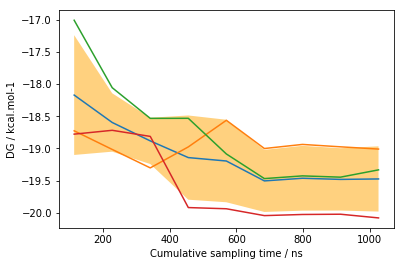

In [19]:
# Plot convergence with current data
plotDGbind(energies)

In [20]:
noisy_windows = getNoisyWindows(energies,EPOCHTIME, mythreshold=THRESHOLD)
print ("The noisy windows (std > %s kcal/mol) are:" % THRESHOLD)
for entry in noisy_windows:
    print (entry)

The noisy windows (std > 0.1 kcal/mol) are:
['bound', 'vanish', '0.00000-0.02500', 0.15146130418911177]
['bound', 'vanish', '0.02500-0.05000', 0.20871815658655288]
['bound', 'vanish', '0.10000-0.12500', 0.23869737232645769]
['bound', 'vanish', '0.12500-0.15000', 0.23063651537044655]
['bound', 'vanish', '0.20000-0.25000', 0.48939128403445126]
['bound', 'vanish', '0.25000-0.30000', 0.36434913963883]
['bound', 'vanish', '0.30000-0.35000', 0.33248689531401915]
['bound', 'vanish', '0.35000-0.40000', 0.17850763444613665]
['bound', 'vanish', '0.40000-0.45000', 0.43683774511316625]
['bound', 'vanish', '0.45000-0.50000', 0.41850978748677103]
['bound', 'vanish', '0.55000-0.60000', 0.11808732173927715]
['free', 'vanish', '0.20000-0.25000', 0.14031489189992946]


In [22]:
import copy
#savesimprofile = copy.deepcopy(simprofile)
fullenergies = copy.deepcopy(energies)

In [ ]:
# Main adaptive loop
for epoch in range(2,NEPOCHS+1):
    print("EPOCH %s " % epoch)
    updateSimProfile(simprofile,noisy_windows,epoch*EPOCHTIME)
    calcEnergies(energies,basefolder, simprofile, epoch)
    plotDGbind(energies)
    noisy_windows = getNoisyWindows(energies,epoch*EPOCHTIME, mythreshold=THRESHOLD)
    print ("The noisy windows (std > %s kcal/mol) are:" % THRESHOLD)
    for entry in noisy_windows:
        print (entry)

In [23]:
#Adaptive loop run manually for debugging
#EPOCH 2
updateSimProfile(simprofile,noisy_windows,10)

sim/bound/run001/vanish/output/lambda-0.000/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.025/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.050/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.100/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.125/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.150/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.200/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.250/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.300/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.350/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/lambda-0.400/simfile.dat noisy, extending sampling to 10
sim/bound/run001/vanish/output/l

In [24]:
#EPOCH2
calcEnergies(energies, basefolder, simprofile, 2)

MBAR on sim/bound/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 5.5, DG {'0.00000-0.05000': (12.7887, 0.002), '0.05000-0.10000': (12.0513, 0.0017), '0.10000-0.20000': (21.9619, 0.0033), '0.20000-0.30000': (19.1771, 0.0033), '0.30000-0.40000': (16.4578, 0.0031), '0.40000-0.50000': (13.7933, 0.003), '0.50000-0.60000': (11.1805, 0.0028), '0.60000-0.70000': (8.6221, 0.0025), '0.70000-0.80000': (6.1202, 0.0023), '0.80000-0.90000': (3.6709, 0.0021), '0.90000-1.00000': (1.2651, 0.0023), 'DGtot': (127.089055, 0.015074, 54.004799999999996)} 
MBAR on sim/bound/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 6.0, DG {'0.00000-0.05000': (12.7887, 0.002), '0.05000-0.10000': (12.0513, 0.0017), '0.10000-0.20000': (21.9619, 0.0033), '0.20000-0.30000': (19.1771, 0.0033), '0.30000-0.40000': (16.4578, 0.0031), '0.40000-0.50000': (13.7933, 0.003), '0.50000-0.60000': (11.1805, 0.0028), '0.60000-0.70000': (8.6221, 0.0025), '0.70000-0.80000': (6.1202, 0.0023), '0.80000-0.90000': (

MBAR on sim/bound/run001/vanish/output/lambda-*/simfile.dat, start 0.5, end 7.0, DG {'0.00000-0.02500': (-14.9156, 0.0122), '0.02500-0.05000': (-8.9189, 0.0105), '0.05000-0.07500': (-4.8744, 0.0101), '0.07500-0.10000': (-2.4749, 0.0109), '0.10000-0.12500': (-1.2975, 0.0098), '0.12500-0.15000': (-0.082, 0.0073), '0.15000-0.20000': (1.496, 0.0322), '0.20000-0.25000': (1.187, 0.0241), '0.25000-0.30000': (0.7745, 0.0255), '0.30000-0.35000': (0.1578, 0.0225), '0.35000-0.40000': (-0.2489, 0.0203), '0.40000-0.45000': (-0.4662, 0.0168), '0.45000-0.50000': (-0.7996, 0.0184), '0.50000-0.55000': (0.048, 0.0101), '0.55000-0.60000': (0.7357, 0.0094), '0.60000-0.65000': (0.6564, 0.0102), '0.65000-0.70000': (0.8235, 0.0073), '0.70000-0.75000': (0.9824, 0.0047), '0.75000-0.80000': (1.5338, 0.0019), '0.80000-0.85000': (1.9501, 0.0009), '0.85000-0.90000': (1.9229, 0.0007), '0.90000-0.95000': (1.6797, 0.0007), '0.95000-0.97000': (0.6263, 0.0003), '0.97000-0.99000': (0.6921, 0.0003), '0.99000-1.00000': (0

MBAR on sim/free/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 6.5, DG {'0.00000-0.05000': (13.08, 0.002), '0.05000-0.10000': (12.3619, 0.0018), '0.10000-0.20000': (22.5897, 0.0036), '0.20000-0.30000': (19.7833, 0.0037), '0.30000-0.40000': (17.0222, 0.0036), '0.40000-0.50000': (14.2928, 0.0036), '0.50000-0.60000': (11.5928, 0.0034), '0.60000-0.70000': (8.9324, 0.0033), '0.70000-0.80000': (6.3242, 0.003), '0.80000-0.90000': (3.7717, 0.0029), '0.90000-1.00000': (1.259, 0.0031), 'DGtot': (131.009857, 0.017165, 54.004799999999996)} 
MBAR on sim/free/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 7.0, DG {'0.00000-0.05000': (13.08, 0.002), '0.05000-0.10000': (12.3619, 0.0018), '0.10000-0.20000': (22.5897, 0.0036), '0.20000-0.30000': (19.7833, 0.0037), '0.30000-0.40000': (17.0222, 0.0036), '0.40000-0.50000': (14.2928, 0.0036), '0.50000-0.60000': (11.5928, 0.0034), '0.60000-0.70000': (8.9324, 0.0033), '0.70000-0.80000': (6.3242, 0.003), '0.80000-0.90000': (3.7717,

MBAR on sim/free/run001/vanish/output/lambda-*/simfile.dat, start 0.5, end 7.5, DG {'0.00000-0.02500': (-14.8664, 0.0131), '0.02500-0.05000': (-9.3338, 0.0117), '0.05000-0.07500': (-5.6971, 0.0108), '0.07500-0.10000': (-3.4391, 0.0104), '0.10000-0.12500': (-1.9276, 0.0092), '0.12500-0.15000': (-0.9172, 0.0089), '0.15000-0.20000': (-0.5432, 0.0242), '0.20000-0.25000': (-0.0864, 0.0215), '0.25000-0.30000': (-0.253, 0.0199), '0.30000-0.35000': (-0.5514, 0.021), '0.35000-0.40000': (-1.0162, 0.0204), '0.40000-0.45000': (-1.602, 0.0211), '0.45000-0.50000': (-2.4585, 0.0212), '0.50000-0.55000': (-2.6548, 0.0169), '0.55000-0.60000': (-1.9602, 0.0124), '0.60000-0.65000': (-1.0337, 0.0094), '0.65000-0.70000': (-0.1862, 0.0062), '0.70000-0.75000': (0.5754, 0.003), '0.75000-0.80000': (1.1592, 0.0013), '0.80000-0.85000': (1.3964, 0.0006), '0.85000-0.90000': (1.3525, 0.0003), '0.90000-0.95000': (1.2037, 0.0002), '0.95000-0.97000': (0.4594, 0.0001), '0.97000-0.99000': (0.5159, 0.0001), '0.99000-1.000

MBAR on sim/bound/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 7.5, DG {'0.00000-0.05000': (12.7141, 0.0019), '0.05000-0.10000': (12.0006, 0.0016), '0.10000-0.20000': (21.9114, 0.0031), '0.20000-0.30000': (19.1761, 0.0032), '0.30000-0.40000': (16.4881, 0.0031), '0.40000-0.50000': (13.831, 0.003), '0.50000-0.60000': (11.211, 0.0028), '0.60000-0.70000': (8.6523, 0.0025), '0.70000-0.80000': (6.1561, 0.0023), '0.80000-0.90000': (3.7027, 0.0022), '0.90000-1.00000': (1.2809, 0.0024), 'DGtot': (127.124404, 0.01487, 54.004799999999996)} 
MBAR on sim/bound/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 8.0, DG {'0.00000-0.05000': (12.7141, 0.0019), '0.05000-0.10000': (12.0006, 0.0016), '0.10000-0.20000': (21.9114, 0.0031), '0.20000-0.30000': (19.1761, 0.0032), '0.30000-0.40000': (16.4881, 0.0031), '0.40000-0.50000': (13.831, 0.003), '0.50000-0.60000': (11.211, 0.0028), '0.60000-0.70000': (8.6523, 0.0025), '0.70000-0.80000': (6.1561, 0.0023), '0.80000-0.90000': (3.7

MBAR on sim/bound/run002/vanish/output/lambda-*/simfile.dat, start 0.5, end 8.0, DG {'0.00000-0.02500': (-14.9792, 0.0109), '0.02500-0.05000': (-8.8406, 0.0096), '0.05000-0.07500': (-4.8439, 0.0099), '0.07500-0.10000': (-2.4167, 0.0101), '0.10000-0.12500': (-0.7546, 0.0069), '0.12500-0.15000': (0.4267, 0.0074), '0.15000-0.20000': (1.8927, 0.0261), '0.20000-0.25000': (1.1918, 0.0319), '0.25000-0.30000': (1.5779, 0.016), '0.30000-0.35000': (0.6307, 0.0277), '0.35000-0.40000': (-0.7588, 0.0217), '0.40000-0.45000': (-1.65, 0.0215), '0.45000-0.50000': (-1.7195, 0.0181), '0.50000-0.55000': (-0.2128, 0.0106), '0.55000-0.60000': (0.7649, 0.0084), '0.60000-0.65000': (0.6198, 0.01), '0.65000-0.70000': (0.6606, 0.0074), '0.70000-0.75000': (1.0704, 0.004), '0.75000-0.80000': (1.5905, 0.0018), '0.80000-0.85000': (1.9028, 0.0008), '0.85000-0.90000': (1.8426, 0.0007), '0.90000-0.95000': (1.6065, 0.0006), '0.95000-0.97000': (0.6011, 0.0003), '0.97000-0.99000': (0.6662, 0.0003), '0.99000-1.00000': (0.7

MBAR on sim/free/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 8.5, DG {'0.00000-0.05000': (13.0894, 0.002), '0.05000-0.10000': (12.3618, 0.0018), '0.10000-0.20000': (22.5806, 0.0036), '0.20000-0.30000': (19.7704, 0.0038), '0.30000-0.40000': (16.9937, 0.0037), '0.40000-0.50000': (14.2605, 0.0035), '0.50000-0.60000': (11.5794, 0.0033), '0.60000-0.70000': (8.9381, 0.0032), '0.70000-0.80000': (6.333, 0.0031), '0.80000-0.90000': (3.7741, 0.0029), '0.90000-1.00000': (1.2572, 0.0031), 'DGtot': (130.938028, 0.017148, 54.004799999999996)} 
MBAR on sim/free/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 9.0, DG {'0.00000-0.05000': (13.0894, 0.002), '0.05000-0.10000': (12.3618, 0.0018), '0.10000-0.20000': (22.5806, 0.0036), '0.20000-0.30000': (19.7704, 0.0038), '0.30000-0.40000': (16.9937, 0.0037), '0.40000-0.50000': (14.2605, 0.0035), '0.50000-0.60000': (11.5794, 0.0033), '0.60000-0.70000': (8.9381, 0.0032), '0.70000-0.80000': (6.333, 0.0031), '0.80000-0.90000': (3.

MBAR on sim/free/run002/vanish/output/lambda-*/simfile.dat, start 0.5, end 8.5, DG {'0.00000-0.02500': (-14.808, 0.0133), '0.02500-0.05000': (-9.3438, 0.0119), '0.05000-0.07500': (-5.7477, 0.011), '0.07500-0.10000': (-3.4344, 0.0102), '0.10000-0.12500': (-1.9059, 0.0093), '0.12500-0.15000': (-0.9322, 0.0089), '0.15000-0.20000': (-0.5281, 0.0238), '0.20000-0.25000': (-0.4314, 0.0197), '0.25000-0.30000': (-0.3585, 0.02), '0.30000-0.35000': (-0.5508, 0.021), '0.35000-0.40000': (-0.9734, 0.0195), '0.40000-0.45000': (-1.5885, 0.0206), '0.45000-0.50000': (-2.3859, 0.0209), '0.50000-0.55000': (-2.597, 0.017), '0.55000-0.60000': (-1.9531, 0.0126), '0.60000-0.65000': (-1.0143, 0.0092), '0.65000-0.70000': (-0.1761, 0.0062), '0.70000-0.75000': (0.5806, 0.003), '0.75000-0.80000': (1.1603, 0.0013), '0.80000-0.85000': (1.3969, 0.0006), '0.85000-0.90000': (1.3532, 0.0003), '0.90000-0.95000': (1.2045, 0.0002), '0.95000-0.97000': (0.4598, 0.0001), '0.97000-0.99000': (0.5163, 0.0001), '0.99000-1.00000':

MBAR on sim/bound/run003/discharge/output/lambda-*/simfile.dat, start 0.5, end 9.5, DG {'0.00000-0.05000': (12.7532, 0.0018), '0.05000-0.10000': (12.0406, 0.0016), '0.10000-0.20000': (21.9634, 0.0033), '0.20000-0.30000': (19.1765, 0.0033), '0.30000-0.40000': (16.4655, 0.0031), '0.40000-0.50000': (13.8181, 0.0029), '0.50000-0.60000': (11.213, 0.0028), '0.60000-0.70000': (8.6502, 0.0025), '0.70000-0.80000': (6.1412, 0.0023), '0.80000-0.90000': (3.6812, 0.0022), '0.90000-1.00000': (1.2586, 0.0024), 'DGtot': (127.161445, 0.015024, 54.004799999999996)} 
MBAR on sim/bound/run003/discharge/output/lambda-*/simfile.dat, start 0.5, end 10.0, DG {'0.00000-0.05000': (12.7532, 0.0018), '0.05000-0.10000': (12.0406, 0.0016), '0.10000-0.20000': (21.9634, 0.0033), '0.20000-0.30000': (19.1765, 0.0033), '0.30000-0.40000': (16.4655, 0.0031), '0.40000-0.50000': (13.8181, 0.0029), '0.50000-0.60000': (11.213, 0.0028), '0.60000-0.70000': (8.6502, 0.0025), '0.70000-0.80000': (6.1412, 0.0023), '0.80000-0.90000'

MBAR on sim/bound/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 9.0, DG {'0.00000-0.02500': (-15.1954, 0.0108), '0.02500-0.05000': (-9.1413, 0.0094), '0.05000-0.07500': (-4.9338, 0.009), '0.07500-0.10000': (-2.3176, 0.0093), '0.10000-0.12500': (-0.8635, 0.0077), '0.12500-0.15000': (0.0726, 0.0072), '0.15000-0.20000': (1.4972, 0.0234), '0.20000-0.25000': (1.9877, 0.0237), '0.25000-0.30000': (1.1384, 0.0197), '0.30000-0.35000': (0.5683, 0.0198), '0.35000-0.40000': (-0.1742, 0.018), '0.40000-0.45000': (-0.5288, 0.0151), '0.45000-0.50000': (-0.6897, 0.0146), '0.50000-0.55000': (0.0207, 0.0095), '0.55000-0.60000': (0.6504, 0.0088), '0.60000-0.65000': (0.6592, 0.0087), '0.65000-0.70000': (0.851, 0.0077), '0.70000-0.75000': (1.0863, 0.0045), '0.75000-0.80000': (1.6481, 0.0018), '0.80000-0.85000': (1.9191, 0.001), '0.85000-0.90000': (1.8019, 0.0007), '0.90000-0.95000': (1.5533, 0.0006), '0.95000-0.97000': (0.5809, 0.0002), '0.97000-0.99000': (0.6449, 0.0003), '0.99000-1.00000': (0.

MBAR on sim/free/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 5.5, DG {'0.00000-0.02500': (-14.9235, 0.0135), '0.02500-0.05000': (-9.4087, 0.0117), '0.05000-0.07500': (-5.7919, 0.011), '0.07500-0.10000': (-3.4543, 0.01), '0.10000-0.12500': (-1.9417, 0.0095), '0.12500-0.15000': (-0.9655, 0.0089), '0.15000-0.20000': (-0.4579, 0.026), '0.20000-0.25000': (-0.079, 0.0242), '0.25000-0.30000': (-0.2033, 0.0226), '0.30000-0.35000': (-0.6268, 0.0211), '0.35000-0.40000': (-0.8763, 0.0186), '0.40000-0.45000': (-1.5962, 0.0216), '0.45000-0.50000': (-2.4329, 0.0206), '0.50000-0.55000': (-2.5525, 0.0166), '0.55000-0.60000': (-1.9221, 0.0126), '0.60000-0.65000': (-1.014, 0.0092), '0.65000-0.70000': (-0.1751, 0.0063), '0.70000-0.75000': (0.573, 0.0031), '0.75000-0.80000': (1.1574, 0.0013), '0.80000-0.85000': (1.395, 0.0006), '0.85000-0.90000': (1.3515, 0.0003), '0.90000-0.95000': (1.2031, 0.0002), '0.95000-0.97000': (0.4593, 0.0001), '0.97000-0.99000': (0.5157, 0.0001), '0.99000-1.00000':

MBAR on sim/free/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 9.5, DG {'0.00000-0.02500': (-14.9235, 0.0135), '0.02500-0.05000': (-9.4087, 0.0117), '0.05000-0.07500': (-5.7919, 0.011), '0.07500-0.10000': (-3.4543, 0.01), '0.10000-0.12500': (-1.9417, 0.0095), '0.12500-0.15000': (-0.9656, 0.0089), '0.15000-0.20000': (-0.428, 0.0217), '0.20000-0.25000': (-0.0021, 0.0179), '0.25000-0.30000': (-0.2048, 0.0201), '0.30000-0.35000': (-0.6268, 0.0211), '0.35000-0.40000': (-0.8763, 0.0186), '0.40000-0.45000': (-1.5962, 0.0216), '0.45000-0.50000': (-2.4329, 0.0206), '0.50000-0.55000': (-2.5525, 0.0166), '0.55000-0.60000': (-1.9221, 0.0126), '0.60000-0.65000': (-1.014, 0.0092), '0.65000-0.70000': (-0.1751, 0.0063), '0.70000-0.75000': (0.573, 0.0031), '0.75000-0.80000': (1.1574, 0.0013), '0.80000-0.85000': (1.395, 0.0006), '0.85000-0.90000': (1.3515, 0.0003), '0.90000-0.95000': (1.2031, 0.0002), '0.95000-0.97000': (0.4593, 0.0001), '0.97000-0.99000': (0.5157, 0.0001), '0.99000-1.00000'

1.0 -18.17174033333332 0.9296405927213136
1.5 -18.597297666666673 0.45319256124781954
2.0 -18.88299033333334 0.35943168960477595
2.5 -19.142285 0.6537237654594253
3.0 -19.195221999999987 0.6404343360938427
3.5 -19.504219000000003 0.4820156980188961
4.0 -19.46310933333334 0.5032362467985346
4.5 -19.480788 0.4840841940686092
5.0 -19.473829999999996 0.5063802485894253
5.5 -19.427513333333327 0.5336123688980908
6.0 -19.47236166666666 0.5508524110851206
6.5 -19.548428999999985 0.5567504667446208
7.0 -19.62704766666667 0.5583697174081663
7.5 -19.73142333333333 0.6440644668914063
8.0 -19.777032333333324 0.6757193755518205
8.5 -19.817419666666662 0.6938148838324778
9.0 -19.887389666666653 0.7186019148029323
9.5 -19.859723666666667 0.6999672579760261
10.0 -19.852934666666656 0.6944664750073232


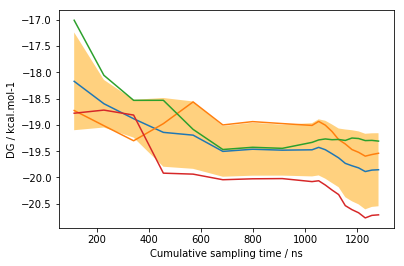

In [25]:
#EPOCH2
plotDGbind(energies)

In [26]:
#EPOCH2
noisy_windows = getNoisyWindows(energies,2*EPOCHTIME)
print ("The noisy windows (std > %s kcal/mol) are:" % THRESHOLD)
for entry in noisy_windows:
    print (entry)

The noisy windows (std > 0.1 kcal/mol) are:
['bound', 'vanish', '0.00000-0.02500', 0.11879262042175266]
['bound', 'vanish', '0.02500-0.05000', 0.1313718978912745]
['bound', 'vanish', '0.10000-0.12500', 0.24007710335547522]
['bound', 'vanish', '0.12500-0.15000', 0.169599023844151]
['bound', 'vanish', '0.15000-0.20000', 0.18588955502304771]
['bound', 'vanish', '0.20000-0.25000', 0.36243648025857195]
['bound', 'vanish', '0.25000-0.30000', 0.28433567408180693]
['bound', 'vanish', '0.30000-0.35000', 0.11126188326047096]
['bound', 'vanish', '0.35000-0.40000', 0.2713971628444189]
['bound', 'vanish', '0.40000-0.45000', 0.45793399815548386]
['bound', 'vanish', '0.45000-0.50000', 0.44657529662483075]
['bound', 'vanish', '0.50000-0.55000', 0.12322051596854947]
['free', 'vanish', '0.20000-0.25000', 0.18839832506922372]


In [27]:
#NOW TEST COMPARISON TO FULL RUN WHERE ALL WINDOWS ARE EXTENDED
noisy_windows = getNoisyWindows(fullenergies,1*EPOCHTIME, mythreshold=0.0)
print ("The noisy windows (std > %s kcal/mol) are:" % 0.0)
for entry in noisy_windows:
    print (entry)

The noisy windows (std > 0.0 kcal/mol) are:
['bound', 'discharge', '0.00000-0.05000', 0.030467140769469516]
['bound', 'discharge', '0.05000-0.10000', 0.02181991954359298]
['bound', 'discharge', '0.10000-0.20000', 0.024167241372476625]
['bound', 'discharge', '0.20000-0.30000', 0.00041096093353030735]
['bound', 'discharge', '0.30000-0.40000', 0.01285880588891887]
['bound', 'discharge', '0.40000-0.50000', 0.01564445233585622]
['bound', 'discharge', '0.50000-0.60000', 0.014871673297469178]
['bound', 'discharge', '0.60000-0.70000', 0.013768159725331065]
['bound', 'discharge', '0.70000-0.80000', 0.014726468989167022]
['bound', 'discharge', '0.80000-0.90000', 0.013247976784735455]
['bound', 'discharge', '0.90000-1.00000', 0.009364115904166642]
['bound', 'vanish', '0.00000-0.02500', 0.15146130418911177]
['bound', 'vanish', '0.02500-0.05000', 0.20871815658655288]
['bound', 'vanish', '0.05000-0.07500', 0.07961684634687675]
['bound', 'vanish', '0.07500-0.10000', 0.048558487071434286]
['bound', 'v

In [28]:
updateSimProfile(simprofile,noisy_windows,10)

sim/bound/run001/discharge/output/lambda-0.000/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.050/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.100/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.200/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.300/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.400/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.500/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.600/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.700/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.800/simfile.dat noisy, extending sampling to 10
sim/bound/run001/discharge/output/lambda-0.900/simfile.dat noisy, extending sampling to 10

In [29]:
calcEnergies(fullenergies, basefolder, simprofile, 2)

MBAR on sim/bound/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 5.5, DG {'0.00000-0.05000': (12.7914, 0.0019), '0.05000-0.10000': (12.0546, 0.0016), '0.10000-0.20000': (21.9713, 0.0031), '0.20000-0.30000': (19.1907, 0.0031), '0.30000-0.40000': (16.4719, 0.003), '0.40000-0.50000': (13.8022, 0.0028), '0.50000-0.60000': (11.1834, 0.0026), '0.60000-0.70000': (8.6226, 0.0024), '0.70000-0.80000': (6.1204, 0.0022), '0.80000-0.90000': (3.6704, 0.002), '0.90000-1.00000': (1.2637, 0.0022), 'DGtot': (127.142543, 0.014315, 60.004799999999996)} 
MBAR on sim/bound/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 6.0, DG {'0.00000-0.05000': (12.7913, 0.0018), '0.05000-0.10000': (12.0551, 0.0016), '0.10000-0.20000': (21.9751, 0.0029), '0.20000-0.30000': (19.1996, 0.003), '0.30000-0.40000': (16.4821, 0.0029), '0.40000-0.50000': (13.8088, 0.0027), '0.50000-0.60000': (11.1862, 0.0025), '0.60000-0.70000': (8.6233, 0.0023), '0.70000-0.80000': (6.1195, 0.0021), '0.80000-0.90000': 

MBAR on sim/bound/run001/vanish/output/lambda-*/simfile.dat, start 0.5, end 7.0, DG {'0.00000-0.02500': (-14.9156, 0.0122), '0.02500-0.05000': (-8.9177, 0.0105), '0.05000-0.07500': (-4.8698, 0.0092), '0.07500-0.10000': (-2.4623, 0.01), '0.10000-0.12500': (-1.2971, 0.0098), '0.12500-0.15000': (-0.082, 0.0073), '0.15000-0.20000': (1.496, 0.0322), '0.20000-0.25000': (1.187, 0.0241), '0.25000-0.30000': (0.7745, 0.0255), '0.30000-0.35000': (0.1578, 0.0225), '0.35000-0.40000': (-0.2489, 0.0203), '0.40000-0.45000': (-0.4662, 0.0168), '0.45000-0.50000': (-0.7996, 0.0184), '0.50000-0.55000': (0.048, 0.0101), '0.55000-0.60000': (0.7334, 0.0095), '0.60000-0.65000': (0.6301, 0.0092), '0.65000-0.70000': (0.8613, 0.006), '0.70000-0.75000': (1.0029, 0.004), '0.75000-0.80000': (1.5424, 0.0016), '0.80000-0.85000': (1.9521, 0.0007), '0.85000-0.90000': (1.919, 0.0006), '0.90000-0.95000': (1.6741, 0.0006), '0.95000-0.97000': (0.6242, 0.0002), '0.97000-0.99000': (0.6899, 0.0003), '0.99000-1.00000': (0.735,

MBAR on sim/free/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 6.5, DG {'0.00000-0.05000': (13.0881, 0.0017), '0.05000-0.10000': (12.367, 0.0015), '0.10000-0.20000': (22.5953, 0.0031), '0.20000-0.30000': (19.7845, 0.0032), '0.30000-0.40000': (17.0188, 0.0032), '0.40000-0.50000': (14.2877, 0.0031), '0.50000-0.60000': (11.5889, 0.003), '0.60000-0.70000': (8.9295, 0.0028), '0.70000-0.80000': (6.3226, 0.0026), '0.80000-0.90000': (3.7719, 0.0025), '0.90000-1.00000': (1.2602, 0.0027), 'DGtot': (131.014536, 0.014879, 72.0048)} 
MBAR on sim/free/run001/discharge/output/lambda-*/simfile.dat, start 0.5, end 7.0, DG {'0.00000-0.05000': (13.0915, 0.0017), '0.05000-0.10000': (12.3694, 0.0015), '0.10000-0.20000': (22.5972, 0.003), '0.20000-0.30000': (19.7831, 0.0031), '0.30000-0.40000': (17.0165, 0.003), '0.40000-0.50000': (14.2884, 0.0029), '0.50000-0.60000': (11.5914, 0.0029), '0.60000-0.70000': (8.931, 0.0027), '0.70000-0.80000': (6.323, 0.0025), '0.80000-0.90000': (3.7718, 0.0024)

MBAR on sim/free/run001/vanish/output/lambda-*/simfile.dat, start 0.5, end 7.5, DG {'0.00000-0.02500': (-14.857, 0.0105), '0.02500-0.05000': (-9.3245, 0.0095), '0.05000-0.07500': (-5.7267, 0.0087), '0.07500-0.10000': (-3.4669, 0.0083), '0.10000-0.12500': (-1.9169, 0.0073), '0.12500-0.15000': (-0.8806, 0.0071), '0.15000-0.20000': (-0.5265, 0.0223), '0.20000-0.25000': (-0.0864, 0.0215), '0.25000-0.30000': (-0.2442, 0.0174), '0.30000-0.35000': (-0.5185, 0.0168), '0.35000-0.40000': (-1.0015, 0.0163), '0.40000-0.45000': (-1.6077, 0.0168), '0.45000-0.50000': (-2.4204, 0.017), '0.50000-0.55000': (-2.6314, 0.0136), '0.55000-0.60000': (-1.9645, 0.0099), '0.60000-0.65000': (-1.022, 0.0075), '0.65000-0.70000': (-0.1787, 0.005), '0.70000-0.75000': (0.5739, 0.0024), '0.75000-0.80000': (1.1593, 0.001), '0.80000-0.85000': (1.3967, 0.0005), '0.85000-0.90000': (1.3526, 0.0002), '0.90000-0.95000': (1.2038, 0.0002), '0.95000-0.97000': (0.4594, 0.0001), '0.97000-0.99000': (0.5159, 0.0001), '0.99000-1.0000

MBAR on sim/bound/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 7.5, DG {'0.00000-0.05000': (12.7115, 0.0015), '0.05000-0.10000': (11.9967, 0.0013), '0.10000-0.20000': (21.9025, 0.0025), '0.20000-0.30000': (19.1755, 0.0025), '0.30000-0.40000': (16.5031, 0.0024), '0.40000-0.50000': (13.8468, 0.0024), '0.50000-0.60000': (11.2154, 0.0023), '0.60000-0.70000': (8.6562, 0.002), '0.70000-0.80000': (6.1671, 0.0018), '0.80000-0.90000': (3.7156, 0.0018), '0.90000-1.00000': (1.2905, 0.0019), 'DGtot': (127.180897, 0.011904, 84.0048)} 
MBAR on sim/bound/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 8.0, DG {'0.00000-0.05000': (12.7102, 0.0015), '0.05000-0.10000': (11.9942, 0.0013), '0.10000-0.20000': (21.8956, 0.0024), '0.20000-0.30000': (19.1704, 0.0024), '0.30000-0.40000': (16.5026, 0.0023), '0.40000-0.50000': (13.8495, 0.0023), '0.50000-0.60000': (11.2175, 0.0022), '0.60000-0.70000': (8.6555, 0.0019), '0.70000-0.80000': (6.1648, 0.0018), '0.80000-0.90000': (3.7133, 

MBAR on sim/bound/run002/vanish/output/lambda-*/simfile.dat, start 0.5, end 8.0, DG {'0.00000-0.02500': (-14.9792, 0.0109), '0.02500-0.05000': (-8.8415, 0.0096), '0.05000-0.07500': (-4.9377, 0.0091), '0.07500-0.10000': (-2.4912, 0.0088), '0.10000-0.12500': (-0.7549, 0.0069), '0.12500-0.15000': (0.4267, 0.0074), '0.15000-0.20000': (1.8927, 0.0261), '0.20000-0.25000': (1.1918, 0.0319), '0.25000-0.30000': (1.5779, 0.016), '0.30000-0.35000': (0.6307, 0.0277), '0.35000-0.40000': (-0.7588, 0.0217), '0.40000-0.45000': (-1.65, 0.0215), '0.45000-0.50000': (-1.7195, 0.0181), '0.50000-0.55000': (-0.2128, 0.0106), '0.55000-0.60000': (0.7618, 0.0085), '0.60000-0.65000': (0.5824, 0.0087), '0.65000-0.70000': (0.7216, 0.0055), '0.70000-0.75000': (1.1402, 0.003), '0.75000-0.80000': (1.6155, 0.0014), '0.80000-0.85000': (1.9041, 0.0007), '0.85000-0.90000': (1.8368, 0.0005), '0.90000-0.95000': (1.5999, 0.0005), '0.95000-0.97000': (0.5987, 0.0002), '0.97000-0.99000': (0.6638, 0.0002), '0.99000-1.00000': (0

MBAR on sim/free/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 8.5, DG {'0.00000-0.05000': (13.0845, 0.0015), '0.05000-0.10000': (12.3604, 0.0013), '0.10000-0.20000': (22.5865, 0.0027), '0.20000-0.30000': (19.7827, 0.0028), '0.30000-0.40000': (17.0041, 0.0028), '0.40000-0.50000': (14.2587, 0.0026), '0.50000-0.60000': (11.5708, 0.0025), '0.60000-0.70000': (8.9342, 0.0024), '0.70000-0.80000': (6.3347, 0.0023), '0.80000-0.90000': (3.777, 0.0022), '0.90000-1.00000': (1.2596, 0.0023), 'DGtot': (130.953148, 0.012834, 96.00479999999999)} 
MBAR on sim/free/run002/discharge/output/lambda-*/simfile.dat, start 0.5, end 9.0, DG {'0.00000-0.05000': (13.0834, 0.0015), '0.05000-0.10000': (12.3595, 0.0013), '0.10000-0.20000': (22.5852, 0.0026), '0.20000-0.30000': (19.7817, 0.0027), '0.30000-0.40000': (17.0026, 0.0027), '0.40000-0.50000': (14.2571, 0.0026), '0.50000-0.60000': (11.5698, 0.0024), '0.60000-0.70000': (8.9334, 0.0023), '0.70000-0.80000': (6.334, 0.0022), '0.80000-0.90000': (3

MBAR on sim/free/run002/vanish/output/lambda-*/simfile.dat, start 0.5, end 8.5, DG {'0.00000-0.02500': (-14.7824, 0.01), '0.02500-0.05000': (-9.3338, 0.009), '0.05000-0.07500': (-5.7426, 0.0082), '0.07500-0.10000': (-3.4454, 0.0077), '0.10000-0.12500': (-1.8931, 0.0069), '0.12500-0.15000': (-0.8974, 0.0066), '0.15000-0.20000': (-0.501, 0.0212), '0.20000-0.25000': (-0.4315, 0.0197), '0.25000-0.30000': (-0.3736, 0.0168), '0.30000-0.35000': (-0.597, 0.0159), '0.35000-0.40000': (-1.0071, 0.0148), '0.40000-0.45000': (-1.5647, 0.0153), '0.45000-0.50000': (-2.3702, 0.0158), '0.50000-0.55000': (-2.5932, 0.0127), '0.55000-0.60000': (-1.9517, 0.0094), '0.60000-0.65000': (-1.02, 0.0069), '0.65000-0.70000': (-0.176, 0.0047), '0.70000-0.75000': (0.5844, 0.0023), '0.75000-0.80000': (1.1622, 0.001), '0.80000-0.85000': (1.3973, 0.0004), '0.85000-0.90000': (1.353, 0.0002), '0.90000-0.95000': (1.2042, 0.0002), '0.95000-0.97000': (0.4596, 0.0001), '0.97000-0.99000': (0.5162, 0.0001), '0.99000-1.00000': (

MBAR on sim/bound/run003/discharge/output/lambda-*/simfile.dat, start 0.5, end 9.5, DG {'0.00000-0.05000': (12.775, 0.0013), '0.05000-0.10000': (12.0635, 0.0012), '0.10000-0.20000': (22.0088, 0.0023), '0.20000-0.30000': (19.2136, 0.0024), '0.30000-0.40000': (16.4847, 0.0022), '0.40000-0.50000': (13.8197, 0.0021), '0.50000-0.60000': (11.2092, 0.0019), '0.60000-0.70000': (8.6544, 0.0018), '0.70000-0.80000': (6.1561, 0.0016), '0.80000-0.90000': (3.7014, 0.0016), '0.90000-1.00000': (1.2792, 0.0017), 'DGtot': (127.365652, 0.010658, 108.00479999999999)} 
MBAR on sim/bound/run003/discharge/output/lambda-*/simfile.dat, start 0.5, end 10.0, DG {'0.00000-0.05000': (12.7749, 0.0012), '0.05000-0.10000': (12.0635, 0.0011), '0.10000-0.20000': (22.0099, 0.0023), '0.20000-0.30000': (19.2168, 0.0023), '0.30000-0.40000': (16.4876, 0.0022), '0.40000-0.50000': (13.8205, 0.002), '0.50000-0.60000': (11.2091, 0.0019), '0.60000-0.70000': (8.6547, 0.0017), '0.70000-0.80000': (6.1561, 0.0016), '0.80000-0.90000'

MBAR on sim/bound/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 9.0, DG {'0.00000-0.02500': (-15.1954, 0.0108), '0.02500-0.05000': (-9.1419, 0.0094), '0.05000-0.07500': (-4.9899, 0.0079), '0.07500-0.10000': (-2.3855, 0.0079), '0.10000-0.12500': (-0.8647, 0.0077), '0.12500-0.15000': (0.0726, 0.0072), '0.15000-0.20000': (1.4972, 0.0234), '0.20000-0.25000': (1.9877, 0.0237), '0.25000-0.30000': (1.1384, 0.0197), '0.30000-0.35000': (0.5683, 0.0198), '0.35000-0.40000': (-0.1742, 0.018), '0.40000-0.45000': (-0.5288, 0.0151), '0.45000-0.50000': (-0.6897, 0.0146), '0.50000-0.55000': (0.0206, 0.0095), '0.55000-0.60000': (0.6569, 0.0087), '0.60000-0.65000': (0.7419, 0.007), '0.65000-0.70000': (0.9148, 0.0056), '0.70000-0.75000': (1.1047, 0.0034), '0.75000-0.80000': (1.6548, 0.0014), '0.80000-0.85000': (1.9504, 0.0008), '0.85000-0.90000': (1.8372, 0.0006), '0.90000-0.95000': (1.5794, 0.0005), '0.95000-0.97000': (0.5889, 0.0002), '0.97000-0.99000': (0.6527, 0.0002), '0.99000-1.00000': (

MBAR on sim/free/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 5.5, DG {'0.00000-0.02500': (-14.9195, 0.0129), '0.02500-0.05000': (-9.3987, 0.0111), '0.05000-0.07500': (-5.776, 0.0104), '0.07500-0.10000': (-3.4444, 0.0095), '0.10000-0.12500': (-1.9536, 0.0091), '0.12500-0.15000': (-0.9791, 0.0085), '0.15000-0.20000': (-0.471, 0.0254), '0.20000-0.25000': (-0.079, 0.0242), '0.25000-0.30000': (-0.2099, 0.022), '0.30000-0.35000': (-0.6148, 0.02), '0.35000-0.40000': (-0.8697, 0.0176), '0.40000-0.45000': (-1.5881, 0.0204), '0.45000-0.50000': (-2.4292, 0.0196), '0.50000-0.55000': (-2.561, 0.0159), '0.55000-0.60000': (-1.927, 0.0119), '0.60000-0.65000': (-1.0152, 0.0087), '0.65000-0.70000': (-0.176, 0.006), '0.70000-0.75000': (0.5731, 0.0029), '0.75000-0.80000': (1.1581, 0.0012), '0.80000-0.85000': (1.3955, 0.0006), '0.85000-0.90000': (1.3517, 0.0003), '0.90000-0.95000': (1.2033, 0.0002), '0.95000-0.97000': (0.4593, 0.0001), '0.97000-0.99000': (0.5158, 0.0001), '0.99000-1.00000': (

MBAR on sim/free/run003/vanish/output/lambda-*/simfile.dat, start 0.5, end 9.5, DG {'0.00000-0.02500': (-14.896, 0.0095), '0.02500-0.05000': (-9.3916, 0.0084), '0.05000-0.07500': (-5.7573, 0.0077), '0.07500-0.10000': (-3.416, 0.0071), '0.10000-0.12500': (-1.9321, 0.0067), '0.12500-0.15000': (-0.9955, 0.0065), '0.15000-0.20000': (-0.4834, 0.0186), '0.20000-0.25000': (-0.0021, 0.0179), '0.25000-0.30000': (-0.2148, 0.0164), '0.30000-0.35000': (-0.608, 0.015), '0.35000-0.40000': (-0.8445, 0.013), '0.40000-0.45000': (-1.5695, 0.0151), '0.45000-0.50000': (-2.4321, 0.0148), '0.50000-0.55000': (-2.5885, 0.0119), '0.55000-0.60000': (-1.9333, 0.0089), '0.60000-0.65000': (-1.0175, 0.0065), '0.65000-0.70000': (-0.1692, 0.0044), '0.70000-0.75000': (0.5759, 0.0022), '0.75000-0.80000': (1.1582, 0.0009), '0.80000-0.85000': (1.3957, 0.0004), '0.85000-0.90000': (1.3522, 0.0002), '0.90000-0.95000': (1.2037, 0.0002), '0.95000-0.97000': (0.4595, 0.0001), '0.97000-0.99000': (0.516, 0.0001), '0.99000-1.00000

1.0 -18.17174033333332 0.9296405927213136
1.5 -18.597297666666673 0.45319256124781954
2.0 -18.88299033333334 0.35943168960477595
2.5 -19.142285 0.6537237654594253
3.0 -19.195221999999987 0.6404343360938427
3.5 -19.504219000000003 0.4820156980188961
4.0 -19.46310933333334 0.5032362467985346
4.5 -19.480788 0.4840841940686092
5.0 -19.473829999999996 0.5063802485894253
5.5 -19.439701666666668 0.5099291399825769
6.0 -19.48307566666668 0.529587512037444
6.5 -19.55803966666667 0.5708759394323504
7.0 -19.599952000000002 0.6164520909817723
7.5 -19.723446000000006 0.7504629979594571
8.0 -19.79515466666666 0.8312262958057982
8.5 -19.835309000000013 0.8712756009143597
9.0 -19.908247666666664 0.9026539300375573
9.5 -19.87189033333333 0.9204417143326776
10.0 -19.848106333333334 0.9355932385865531


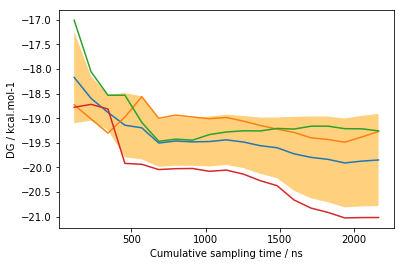

In [30]:
plotDGbind(fullenergies)